https://colab.research.google.com/github/JunetaeKim/GCSP-HBDA/blob/main/Week7/PM10_l1l2.ipynb

# TensorFlow DNN Tutorial - Jupyter Notebook Version

## **Introduction to Deep Learning with TensorFlow**

This provides a tutorial on implementing deep neural networks (DNN) using TensorFlow. 
It focuses on applying L1 and L2 regularization using TensorFlow's built-in functions for efficiency and using the Functional API.

Deep learning models tend to overfit, meaning they memorize the training data rather than generalizing well to unseen data. Regularization techniques such as L1 (Lasso) and L2 (Ridge) help improve generalization by constraining the model's parameters. 

In this tutorial, we will explore how to apply these techniques efficiently using TensorFlow's Functional API.

## **1. Setting Up TensorFlow**

In [1]:
#!pip install tensorflow numpy matplotlib scikit-learn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(tf.__version__)

2.10.0


## **2. Loading and Preprocessing the GEMPM Dataset**
The GEMPM dataset is stored in a GitHub repository. We download the dataset files.

In [3]:
# Define the base URL for the dataset files
base_url = "https://raw.githubusercontent.com/JunetaeKim/GCSP-HBDA/main/Week7/Data/PM/"

# List of CSV files in the repository
file_names = ["pmgeo0.csv", "pmgeo1.csv", "pmgeo2.csv", "pmgeo3.csv", "pmgeo4.csv"]  # Update with actual file names

# Load all CSV files directly from GitHub
pmgeo_list = [pd.read_csv(base_url + file) for file in file_names]
pmgeo = pd.concat(pmgeo_list, axis=0)

# Drop unnecessary columns
pmgeo = pmgeo.drop(columns=['TMSID', 'CODE', 'DATE', 'yr'])

# Separate features and target
X = pmgeo.drop(columns=['PM10'])  # Drop target variable
y = pmgeo['PM10']  # Target variable

# Compute variance for each feature
selector = VarianceThreshold()
selector.fit(X)

# Get feature variances and select top 50 features
variances = selector.variances_
top_50_indices = np.argsort(variances)[-50:]  # Select top 50 indices
X_selected = X.iloc[:, top_50_indices]  # Filter top 50 features

# Normalize the selected features using Min-Max scaling
scaler = MinMaxScaler()
X_selected = scaler.fit_transform(X_selected)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

## **3.  Implementing L1 & L2 Regularization with Functional API**

### **Define a Functional API Model with Built-in L1/L2 Regularization**

TensorFlow provides built-in regularization functions (tf.keras.regularizers.l1_l2) to efficiently apply L1 and L2 constraints.

In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1_l2

# Define input layer
inputs = Input(shape=(X_selected.shape[1],))

# Hidden layers with built-in L1/L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(inputs)
x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)

# Output layer
outputs = Dense(1, activation='linear')(x)  # Regression task

# Define model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

## **4.Training the Model**

### **Train Using Standard Training Loop**

In [5]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1537/1537 [==============================] - 5s 3ms/step - loss: 430.4039 - mae: 15.3896 - val_loss: 296.1711 - val_mae: 13.2466
Epoch 2/10
1537/1537 [==============================] - 4s 2ms/step - loss: 297.5624 - mae: 13.2068 - val_loss: 287.0688 - val_mae: 12.9545
Epoch 3/10
1537/1537 [==============================] - 4s 2ms/step - loss: 292.8362 - mae: 13.1078 - val_loss: 285.3163 - val_mae: 12.9737
Epoch 4/10
1537/1537 [==============================] - 4s 2ms/step - loss: 290.6204 - mae: 13.0698 - val_loss: 282.8764 - val_mae: 12.8892
Epoch 5/10
1537/1537 [==============================] - 4s 2ms/step - loss: 288.9783 - mae: 13.0415 - val_loss: 293.7571 - val_mae: 13.3434
Epoch 6/10
1527/1537 [============================>.] - ETA: 0s - loss: 288.0065 - mae: 13.0282


KeyboardInterrupt



## **5. Understanding the Impact of L1 & L2 Regularization**

### **Display Regularized Weights**
#### Regularization affects the weight distribution, pushing unnecessary weights toward zero and reducing complexity.

In [6]:
for layer in model.layers:
    if hasattr(layer, 'kernel'):
        print(f'Layer: {layer.name}, Regularized Weights: {layer.kernel.numpy()}')

Layer: dense, Regularized Weights: [[ 2.6534125e-01 -8.9725040e-02  2.4005839e-01 ...  2.0359300e-01
   1.1534183e-01  1.4038186e-04]
 [ 2.8669194e-05  1.6920592e-01  1.5567750e-01 ... -2.0224988e-03
   6.0236704e-02 -7.6438220e-05]
 [-8.7607699e-03  2.3401415e-01  8.4443986e-03 ...  6.7540286e-03
  -8.4244553e-03 -2.4936235e-04]
 ...
 [-8.9310497e-02  3.4388795e-02 -1.7660523e-03 ... -1.6467180e-03
  -1.1729769e-02  6.7379326e-05]
 [-1.9556428e-03  2.0708694e-01 -7.3959224e-02 ... -1.5202112e-03
   4.1488517e-02  1.1811633e-05]
 [ 1.0306787e-01  9.4210431e-03  4.5820627e-02 ...  2.1488130e-01
   3.9813425e-02 -8.9350542e-05]]
Layer: dense_1, Regularized Weights: [[-1.32886023e-04  6.62027451e-05  1.93611195e-04 ... -1.63746634e-04
   1.04286559e-01 -6.70497830e-05]
 [ 8.93651159e-05  6.52805029e-05 -2.26877382e-05 ...  1.30410306e-04
  -1.63893133e-01  6.85183622e-05]
 [-2.20787333e-05 -2.58535147e-04 -1.92444990e-04 ...  8.91861200e-05
   1.85155310e-04  7.42166376e-05]
 ...
 [ 1.304

### **Compare Model Performance**
#### We evaluate the model on the test set to understand how well it generalizes.

In [7]:
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

385/385 [==============================] - 1s 1ms/step - loss: 281.4148 - mae: 12.7994
Test Loss: 281.414794921875, Test MAE: 12.799354553222656


## **6. Visualizing Regularization Effects**

### **Plot Weight Distribution**
#### A well-regularized model has weights that are neither too large nor too small.
#### The following histogram visualizes weight distribution.

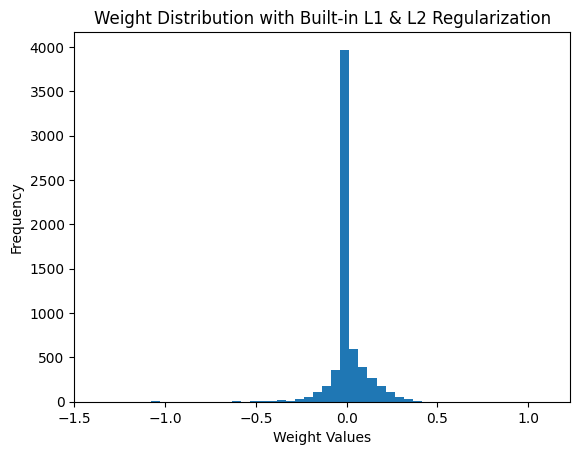

In [8]:
weights = model.layers[1].get_weights()[0].flatten()
plt.hist(weights, bins=50)
plt.title('Weight Distribution with Built-in L1 & L2 Regularization')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.show()

#### **L1 Regularization**: Encourages sparsity, useful for feature selection.

#### **L2 Regularization**: Prevents large weights, leading to more stable models.

#### **Using Functional API**: Provides flexibility and modularity in model design.